In [1]:
import re
from pathlib import Path
import glob
import os

def _read_text_any_encoding(path):
    raw = Path(path).read_bytes()

    if raw.startswith(b'\xff\xfe') or raw.startswith(b'\xfe\xff'):
        encoding = 'utf-16'
    elif raw.startswith(b'\xef\xbb\xbf'):
        encoding = 'utf-8-sig'
    else:
        encoding = None
        for enc in ('utf-8', 'cp1252', 'latin-1'):
            try:
                raw.decode(enc)
                encoding = enc
                break
            except UnicodeDecodeError:
                continue
        if encoding is None:
            encoding = 'latin-1'

    return raw.decode(encoding, errors='replace')

def extract_d_rows(filename):
    text = _read_text_any_encoding(filename)
    extracted = []

    for line in text.splitlines():
        line = line.replace('\x00', '')
        line = line.lstrip('\ufeff\u200b\u2060\xa0 \t')  

        if re.match(r'^[Dd]', line):
            values = [v for v in re.split(r'[,\t; ]+', line) if v]
            extracted.append(values)

    return extracted


def process_all_txt_files(folder_path):
    data_dict = {}

    for filepath in glob.glob(os.path.join(folder_path, "*.txt")):
        key = os.path.splitext(os.path.basename(filepath))[0]

        # Extract rows
        rows = extract_d_rows(filepath)

        # Store MPa, lat, long in list
        extracted = []
        for r in rows:
            try:
                extracted.append((float(r[-4]), float(r[-3]), float(r[-2])))
            except (ValueError, IndexError):
                continue

        data_dict[key] = extracted

    return data_dict

folder = r"C:\Users\telukkari\Documents\Data\Lieksa_kantavuusmittaukset"
all_data = process_all_txt_files(folder)

for k, v in all_data.items():
    print(f"{k}: {len(v)} rows")
    print(v[:3])

Hanhivaarantie_Hattuvaara: 110 rows
[(198.0, 6315.86237, 3026.964), (155.0, 6315.8835, 3026.92889), (51.0, 6315.90743, 3026.94885)]
Inkeriläntie_Isonvaara: 103 rows
[(159.0, 6317.72417, 3017.08722), (151.0, 6317.74614, 3017.12054), (66.0, 6317.76505, 3017.16122)]
Jaakonvaarantiehaara_Emo: 126 rows
[(177.0, 6310.75642, 3014.83016), (195.0, 6310.73377, 3014.79944), (44.0, 6310.71073, 3014.76907)]
Larinvaarantie_Oinola: 53 rows
[(145.0, 6311.13509, 3031.74244), (29.0, 6311.16063, 3031.75933), (83.0, 6311.18317, 3031.79604)]
Lipinvaarantie_Luhovaara: 242 rows
[(189.0, 6310.99479, 3028.38937), (255.0, 6310.97872, 3028.45059), (99.0, 6310.96833, 3028.49145)]
Ranta-ahontie haara_julo: 14 rows
[(103.0, 6311.37578, 3029.10358), (25.0, 6311.40106, 3029.12302), (49.0, 6311.42657, 3029.14272)]
Suontauksentie_Kontiovaara: 83 rows
[(50.0, 6310.51619, 3033.1717), (52.0, 6310.4996, 3033.12458), (37.0, 6310.48383, 3033.07668)]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform
from rasterio.transform import array_bounds
from shapely.geometry import Point
from rasterio.plot import show
import geopandas as gpd
from pyproj import Transformer

def nmea_to_decimal(coord, hemisphere):
    coord = float(coord)
    if hemisphere in ['N','S']:
        degrees = int(coord // 100)
        minutes = coord - degrees * 100
    else:  
        degrees = int(coord // 100)
        minutes = coord - degrees * 100
    
    decimal = degrees + minutes / 60.0
    
    if hemisphere in ['S','W']:
        decimal = -decimal
    return decimal

for key, data in all_data.items():
    print(f"Processing {key} with {len(data)} points")
    mpa = np.array([t[0] for t in data], dtype=float)
    lons = np.array([nmea_to_decimal(t[1], 'E')  for t in data], dtype=float)
    lats = np.array([nmea_to_decimal(t[2], 'N') for t in data], dtype=float)
    to_tm35 = Transformer.from_crs("EPSG:4326", "EPSG:3067", always_xy=True)
    xs, ys = to_tm35.transform(lats, lons)

    print(xs[0], ys[0])


Processing Hanhivaarantie_Hattuvaara with 110 points
673076.7284292739 7019700.315328252
Processing Inkeriläntie_Isonvaara with 103 points
664645.5826654527 7022720.629820288
Processing Jaakonvaarantiehaara_Emo with 126 points
663416.0960348095 7009697.722593522
Processing Larinvaarantie_Oinola with 53 points
677552.5905328043 7011149.049043946
Processing Lipinvaarantie_Luhovaara with 242 points
674757.0955352939 7010735.383325999
Processing Ranta-ahontie haara_julo with 14 points
675317.1880220661 7011474.579113952
Processing Suontauksentie_Kontiovaara with 83 points
678813.7701847918 7010067.2006459255


In [3]:
import os
import rasterio

folder_path = r"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1"
point = (673076.7284292739, 7019700.315328252) 
point1 = (664645.5826654527, 7022720.629820288)
point2 = (663416.0960348095, 7009697.722593522)
point3 = (677552.5905328043, 7011149.049043946)
point4 = (674757.0955352939, 7010735.383325999)
point5 = (675317.1880220661, 7011474.579113952)
point6 = (678813.7701847918, 7010067.2006459255)

matching_files = []

for point in [point, point1, point2, point3, point4, point5, point6]:
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".tif"):
            tif_path = os.path.join(folder_path, fname)
            try:
                with rasterio.open(tif_path) as ds:
                    left, bottom, right, top = ds.bounds
                    x, y = point
                    if (left <= x <= right) and (bottom <= y <= top):
                        matching_files.append(tif_path)
            except Exception as e:
                print(f"Could not open {tif_path}: {e}")

if matching_files:
    print("Points are inside these rasters:")
    for f in matching_files:
        print("  ", f)
else:
    print("No raster in folder covers the point.")

Points are inside these rasters:
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5434A.tif
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5432H.tif
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5431H.tif
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5433D.tif
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5433D.tif
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5433D.tif
   C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_1\P5433D.tif


c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(


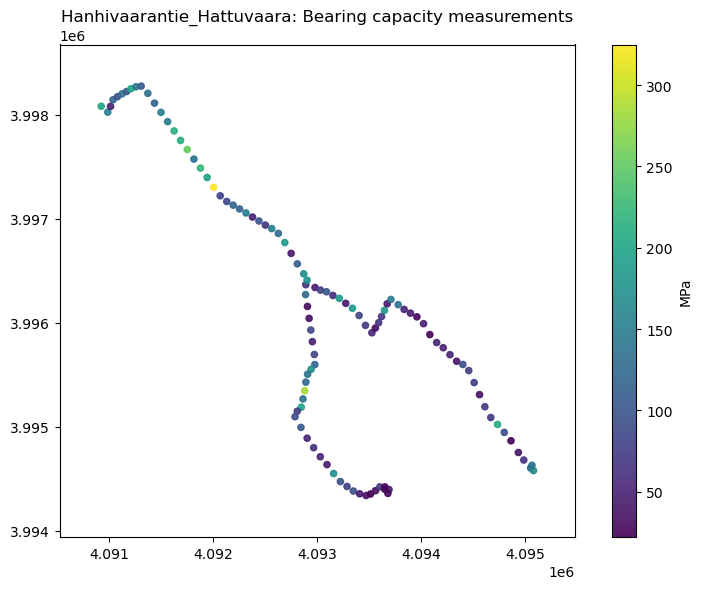

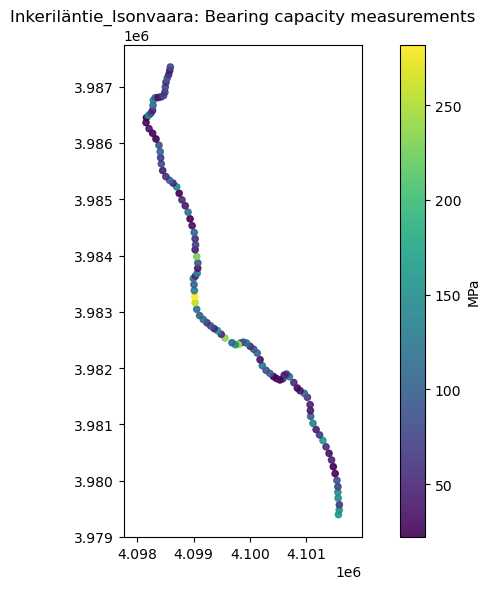

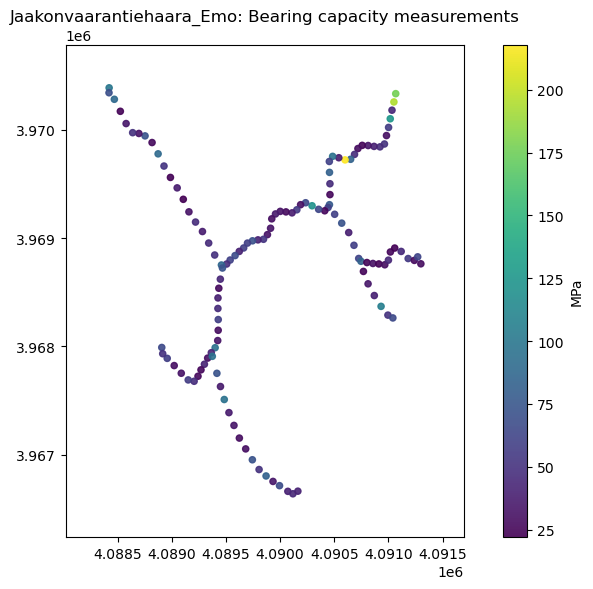

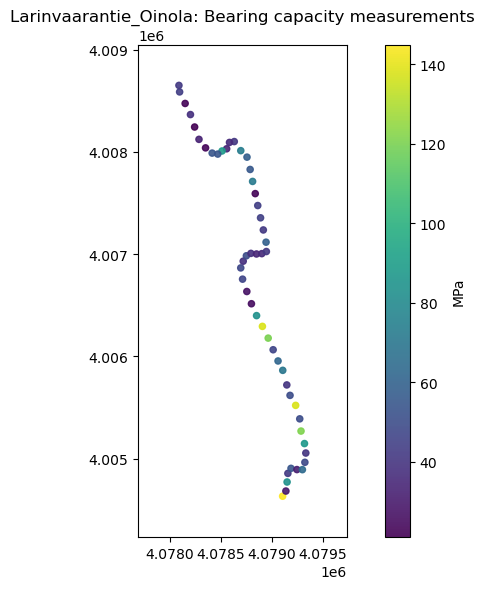

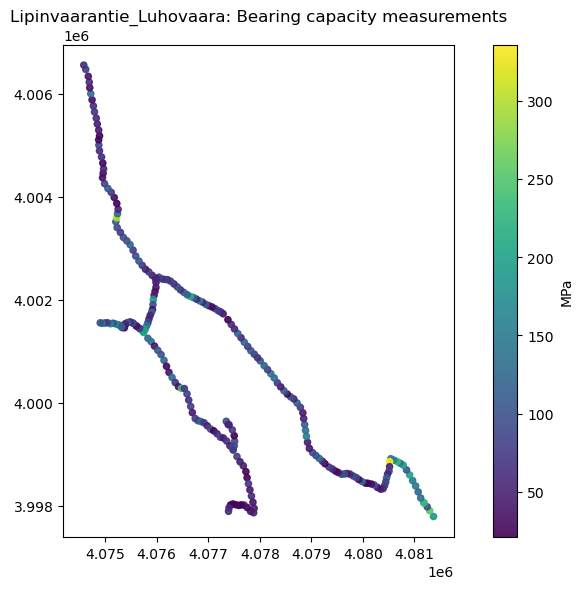

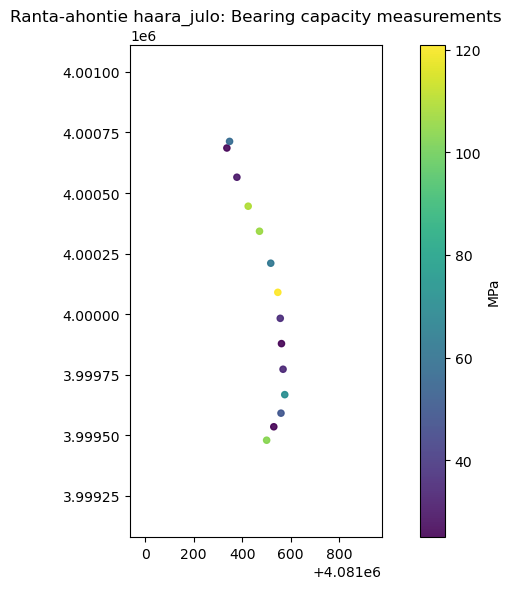

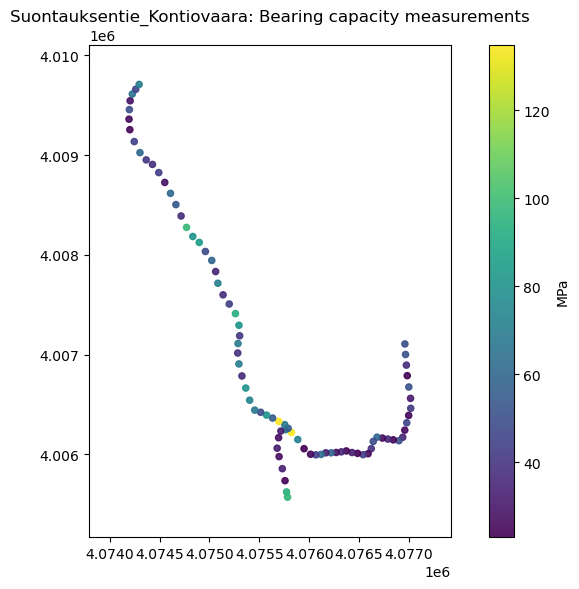

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from pyproj import Transformer
from matplotlib.colors import Normalize

# Road network
shape_path = r"C:\Users\telukkari\Documents\Data\Tieverkosto_pohjois_karjala\vayla\digiroad\2022\Digiroad_K\shp\POHJOIS-KARJALA\POHJOIS-KARJALA_1\DR_LINKKI_K.shp"
gdf = gpd.read_file(shape_path)

to_tm35 = Transformer.from_crs("EPSG:4326", "EPSG:3067", always_xy=True)

for key, data in all_data.items():
    # Extract measurements
    mpa  = np.array([t[0] for t in data], dtype=float)
    lons = np.array([nmea_to_decimal(t[1], 'E') for t in data], dtype=float)
    lats = np.array([nmea_to_decimal(t[2], 'N') for t in data], dtype=float)

    xs, ys = to_tm35.transform(lons, lats)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f"{key}: Bearing capacity measurements")

    gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.3)

    sc = ax.scatter(xs, ys, c=mpa, cmap="viridis", s=20, alpha=0.9)
    plt.colorbar(sc, ax=ax, label="MPa")

    pad = 400
    ax.set_xlim(xs.min() - pad, xs.max() + pad)
    ax.set_ylim(ys.min() - pad, ys.max() + pad)

    plt.tight_layout()
    plt.show()


c:\Users\telukkari\AppData\Local\anaconda3\Lib\site-packages\pyogrio\raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D LineString' is converted to 'LineString Z'
  return ogr_read(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


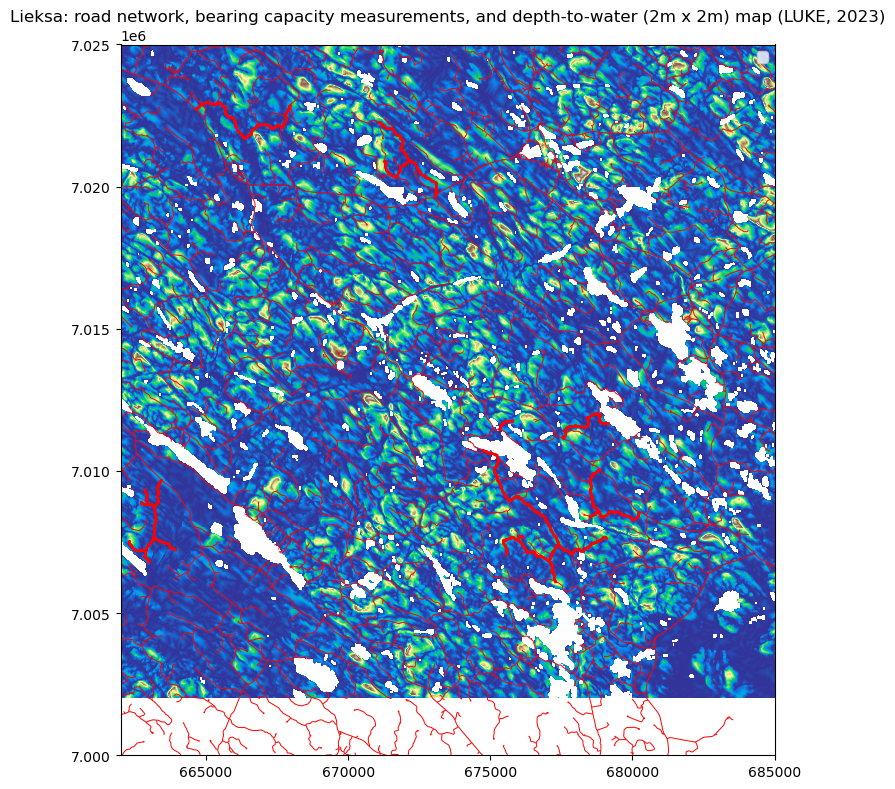

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import transform
from rasterio.transform import array_bounds
from shapely.geometry import Point
from rasterio.plot import show
import geopandas as gpd
from pyproj import Transformer

def nmea_to_decimal(coord, hemisphere):
    coord = float(coord)
    if hemisphere in ['N','S']:
        degrees = int(coord // 100)
        minutes = coord - degrees * 100
    else:  
        degrees = int(coord // 100)
        minutes = coord - degrees * 100
    
    decimal = degrees + minutes / 60.0
    
    if hemisphere in ['S','W']:
        decimal = -decimal
    return decimal

area = 2

tif_path_1 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5434B.tif"
tif_path_2 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5434A.tif"
tif_path_3 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5432H.tif"
tif_path_4 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5431H.tif"
tif_path_5 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5433D.tif"
tif_path_6 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5432G.tif"
tif_path_7 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5434C.tif"
tif_path_8 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5434D.tif"
tif_path_9 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5433B.tif"
tif_path_10 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5433C.tif"  
tif_path_11 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5431G.tif"
tif_path_12 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5433A.tif"
tif_path_13 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5433E.tif"
tif_path_14 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5433F.tif"
tif_path_15 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5434E.tif"
tif_path_16 = rf"C:\Users\telukkari\Documents\Data\Depth_to_water\luke\dtw\2023\DTW_INT_CMv2_{area}\P5434F.tif"

tif_paths = [tif_path_1, tif_path_2, tif_path_3, tif_path_4, tif_path_5, tif_path_6, tif_path_7, tif_path_8, tif_path_9, tif_path_10, tif_path_11, tif_path_12, tif_path_13, tif_path_14, tif_path_15, tif_path_16]

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

for tif in tif_paths:
    with rasterio.open(tif) as src:
        show(src, ax=ax, cmap="terrain")

ax.set_title("Bearing capacity measurements on top of water-to-depth map")

corrected_data = {}

# Road network
shape_path = r"C:\Users\telukkari\Documents\Data\Tieverkosto_pohjois_karjala\vayla\digiroad\2022\Digiroad_K\shp\POHJOIS-KARJALA\POHJOIS-KARJALA_1\DR_LINKKI_K.shp"
gdf = gpd.read_file(shape_path)
gdf.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=0.7)


# Measurements
for key, data in all_data.items():
    mpa = np.array([t[0] for t in data], dtype=float)
    lons = np.array([nmea_to_decimal(t[1], 'E')  for t in data], dtype=float)
    lats = np.array([nmea_to_decimal(t[2], 'N') for t in data], dtype=float)

    to_tm35 = Transformer.from_crs("EPSG:4326", "EPSG:3067", always_xy=True)
    xs, ys = to_tm35.transform(lats, lons)

    for i in range(len(lons)):
        x, y = xs[i], ys[i]
        ax.scatter(x, y, c="red", s=1.5, alpha=1.0)

    corrected_data[key] = [mpa, xs, ys]

ax.set_xlim(662000, 685000)
ax.set_ylim(7000000, 7025000)

ax.legend()
ax.set_title(f"Lieksa: road network, bearing capacity measurements, and depth-to-water (2m x 2m) map (LUKE, 2023)")
plt.tight_layout()
plt.show()


Processed Hanhivaarantie_Hattuvaara, extracted 110 / 110 valid DTW values
Processed Inkeriläntie_Isonvaara, extracted 103 / 103 valid DTW values
Processed Jaakonvaarantiehaara_Emo, extracted 126 / 126 valid DTW values
Processed Larinvaarantie_Oinola, extracted 53 / 53 valid DTW values
Processed Lipinvaarantie_Luhovaara, extracted 242 / 242 valid DTW values
Processed Ranta-ahontie haara_julo, extracted 14 / 14 valid DTW values
Processed Suontauksentie_Kontiovaara, extracted 83 / 83 valid DTW values


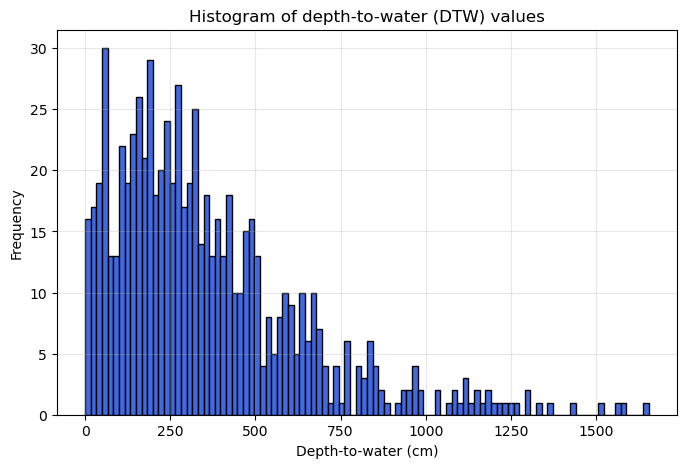

In [6]:
import rasterio
import numpy as np
import rasterio
from rasterio import sample
from pyproj import Transformer

dtws = []
mpas = []

for i, (key, value) in enumerate(corrected_data.items()):
    mpa, xs, ys = value
    coords = list(zip(xs, ys))

    dtw_buffer = []
    mpa_buffer = []

    for tif in tif_paths:
        with rasterio.open(tif) as src:
            vals = list(src.sample(coords))
            dtw = np.vstack(vals)                      
            nd = {v for v in src.nodatavals if v is not None}
            if len(nd) == 1:
                ndv = next(iter(nd))
                indices = np.where(dtw == ndv)
                mask = dtw != ndv
                n_no_values = np.sum(~mask)
                dtw_masked = dtw[mask]
                mpa = mpa.reshape(-1, 1) 
                mpa_masked = mpa[mask]
                dtw_buffer.append(dtw_masked)
                mpa_buffer.append(mpa_masked)

    dtws.append([x for sublist in dtw_buffer for x in sublist])
    mpas.append([x for sublist in mpa_buffer for x in sublist])

    print(f"Processed {key}, extracted {len(dtws[-1])} / {len(mpa)} valid DTW values")

dtws_flatten = [x for sublist in dtws for x in sublist]
mpas_flatten = [x for sublist in mpas for x in sublist]

plt.figure(figsize=(8, 5))
plt.hist(dtws_flatten, bins=100, color="royalblue", edgecolor="black")
plt.title("Histogram of depth-to-water (DTW) values")
plt.xlabel("Depth-to-water (cm)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


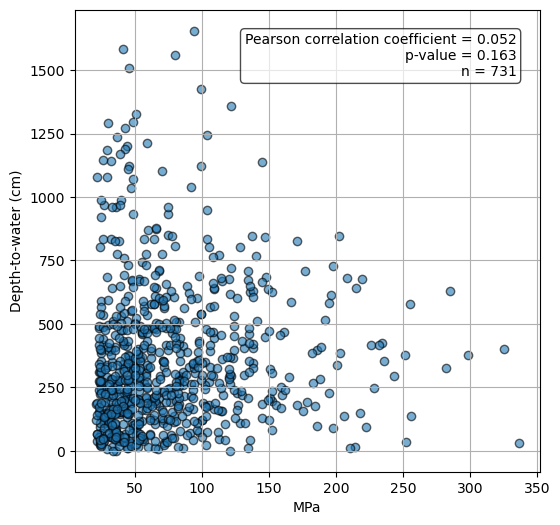

Pearson correlation coefficient: 0.052, p-value: 0.163, n = 731


In [7]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

arr = np.array(dtws_flatten)
mpa = np.array(mpas_flatten)

plt.figure(figsize=(6,6))
plt.scatter(mpa, arr, alpha=0.6, edgecolor='k')

# Labels and grid
plt.xlabel("MPa")
plt.ylabel("Depth-to-water (cm)")
plt.grid(True)

# Pearson correlation
pearson_r_value, p_value = sc.stats.pearsonr(mpa, arr)
n = len(arr)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.3f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)

plt.show()

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.3f}, n = {n}")


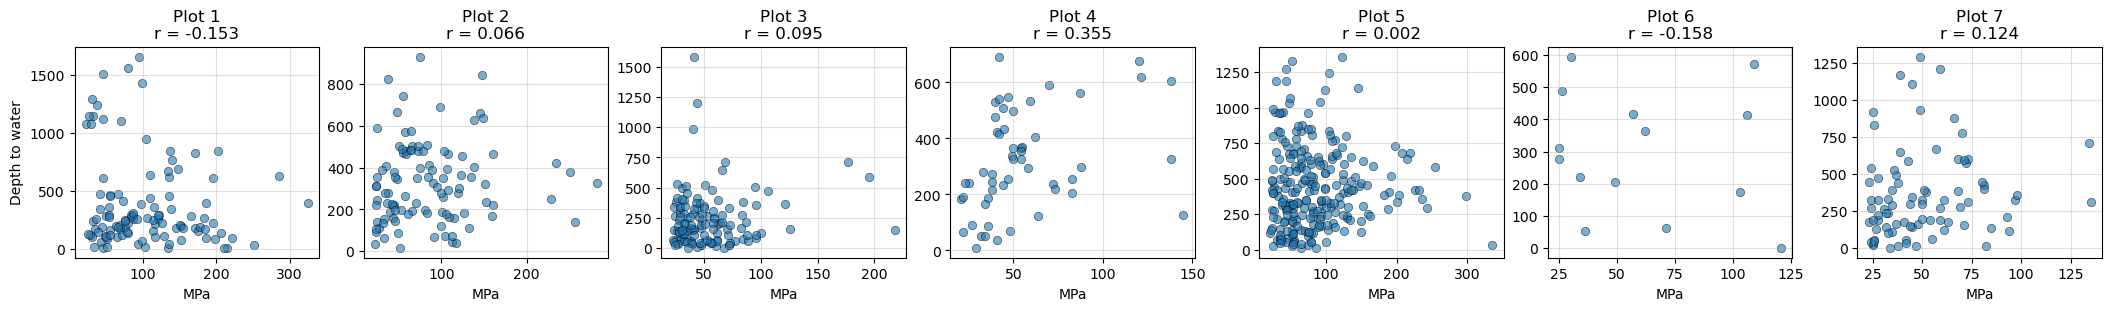

In [8]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 7, figsize=(21, 3), constrained_layout=True)

pearsons = []
for i, ax in enumerate(axes):
    arr = np.asarray(dtws[i], dtype=float)
    mpa = np.asarray(mpas[i], dtype=float)

    mask = np.isfinite(arr) & np.isfinite(mpa)
    arr = arr[mask]
    mpa = mpa[mask]

    ax.scatter(mpa, arr, alpha=0.6, edgecolors='k', linewidth=0.5)
    if i == 0:
        ax.set_ylabel("Depth to water")
    ax.set_xlabel("MPa")
    ax.grid(True, alpha=0.4)

    if mpa.size >= 2:
        r = float(np.corrcoef(mpa, arr)[0, 1])
    else:
        r = np.nan

    pearsons.append(r)
    ax.set_title(f"Plot {i+1}\nr = {r:.3f}" if np.isfinite(r) else f"Plot {i+1}\nr = NA")

plt.show()

In [9]:
# TODO: correlations separately for different road types

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


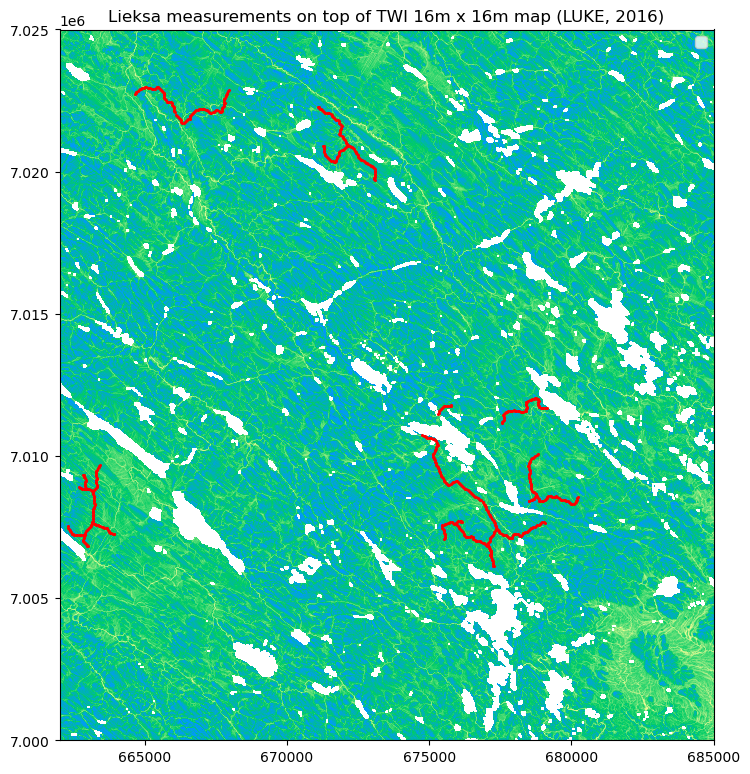

In [10]:
twi_16_path = r"C:\Users\telukkari\Documents\Data\wetness_index_16m2_2016\luke\twi\TWI_16m_Finland_NA_lakes_int.tif"
fig, ax = plt.subplots(figsize=(10, 8))


with rasterio.open(twi_16_path) as src:
    show(src, ax=ax, cmap="terrain")

# Measurements
for key, data in all_data.items():
    mpa = np.array([t[0] for t in data], dtype=float)
    lons = np.array([nmea_to_decimal(t[1], 'E')  for t in data], dtype=float)
    lats = np.array([nmea_to_decimal(t[2], 'N') for t in data], dtype=float)

    to_tm35 = Transformer.from_crs("EPSG:4326", "EPSG:3067", always_xy=True)
    xs, ys = to_tm35.transform(lats, lons)

    for i in range(len(lons)):
        x, y = xs[i], ys[i]
        ax.scatter(x, y, c="red", s=1.5, alpha=1.0)

    corrected_data[key] = [mpa, xs, ys]

ax.set_xlim(662000, 685000)
ax.set_ylim(7000000, 7025000)

ax.legend()
ax.set_title(f"Lieksa measurements on top of TWI 16m x 16m map (LUKE, 2016)")
plt.tight_layout()
plt.show()

Processed Hanhivaarantie_Hattuvaara, extracted 110 / 110 valid TWI values
Processed Inkeriläntie_Isonvaara, extracted 103 / 103 valid TWI values
Processed Jaakonvaarantiehaara_Emo, extracted 126 / 126 valid TWI values
Processed Larinvaarantie_Oinola, extracted 53 / 53 valid TWI values
Processed Lipinvaarantie_Luhovaara, extracted 242 / 242 valid TWI values
Processed Ranta-ahontie haara_julo, extracted 14 / 14 valid TWI values
Processed Suontauksentie_Kontiovaara, extracted 83 / 83 valid TWI values


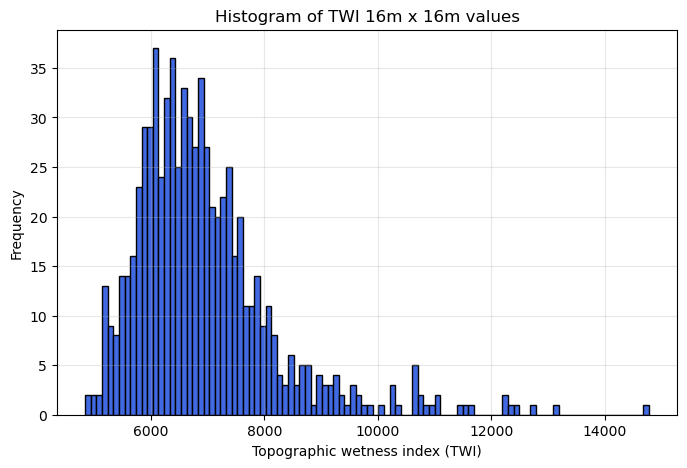

In [11]:
twis = []
mpas = []

twi_16_path = r"C:\Users\telukkari\Documents\Data\wetness_index_16m2_2016\luke\twi\TWI_16m_Finland_NA_lakes_int.tif"


for i, (key, value) in enumerate(corrected_data.items()):
    mpa, xs, ys = value
    coords = list(zip(xs, ys))

    with rasterio.open(twi_16_path) as src:
        vals = list(src.sample(coords))
        twi = np.vstack(vals)                             # shape: (n_points, n_bands)
        nd = {v for v in src.nodatavals if v is not None}
        if len(nd) == 1:
            ndv = next(iter(nd))
            indices = np.where(twi == ndv)
            mask = twi != ndv
            n_no_values = np.sum(~mask)
            twi_masked = twi[mask]
            mpa = mpa.reshape(-1, 1) 
            mpa_masked = mpa[mask]
            twis.append(twi_masked)
            mpas.append(mpa_masked)

    print(f"Processed {key}, extracted {len(twis[-1])} / {len(mpa)} valid TWI values")

twis_flatten = [x for sublist in twis for x in sublist]
mpas_flatten = [x for sublist in mpas for x in sublist]

plt.figure(figsize=(8, 5))
plt.hist(twis_flatten, bins=100, color="royalblue", edgecolor="black")
plt.title("Histogram of TWI 16m x 16m values")
plt.xlabel("Topographic wetness index (TWI)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


Number of measurements: 731


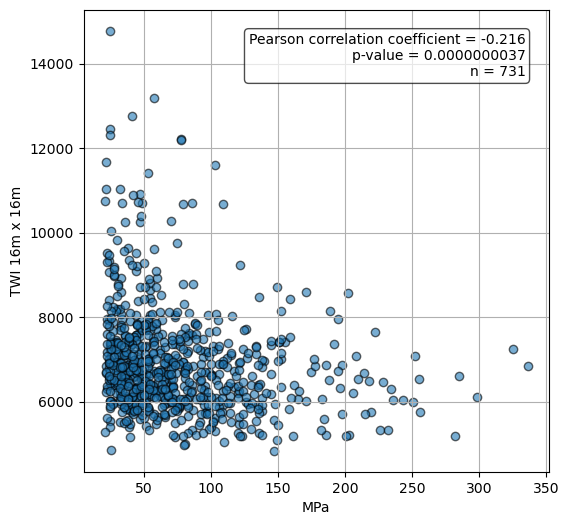

Pearson correlation coefficient: -0.216, p-value: 0.0000000037


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

print(f"Number of measurements: {len(twis_flatten)}")
arr = np.array(twis_flatten)
mpa = np.array(mpas_flatten)

plt.figure(figsize=(6,6))
plt.scatter(mpa, arr, alpha=0.6, edgecolor='k')

pearson_r_value, p_value = sc.stats.pearsonr(mpa, arr)
n = len(arr)

# Add text to top-right corner
plt.text(
    0.95, 0.95,
    f"Pearson correlation coefficient = {pearson_r_value:.3f}\n"
    f"p-value = {p_value:.10f}\n"
    f"n = {n}",
    ha='right', va='top',
    transform=plt.gca().transAxes,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7)
)


plt.xlabel("MPa")
plt.ylabel("TWI 16m x 16m")
plt.grid(True)
plt.show()

# pearson_r = np.corrcoef(mpa, arr)[0, 1]
pearson_r_value, p_value = sc.stats.pearsonr(mpa, arr)

print(f"Pearson correlation coefficient: {pearson_r_value:.3f}, p-value: {p_value:.10f}")

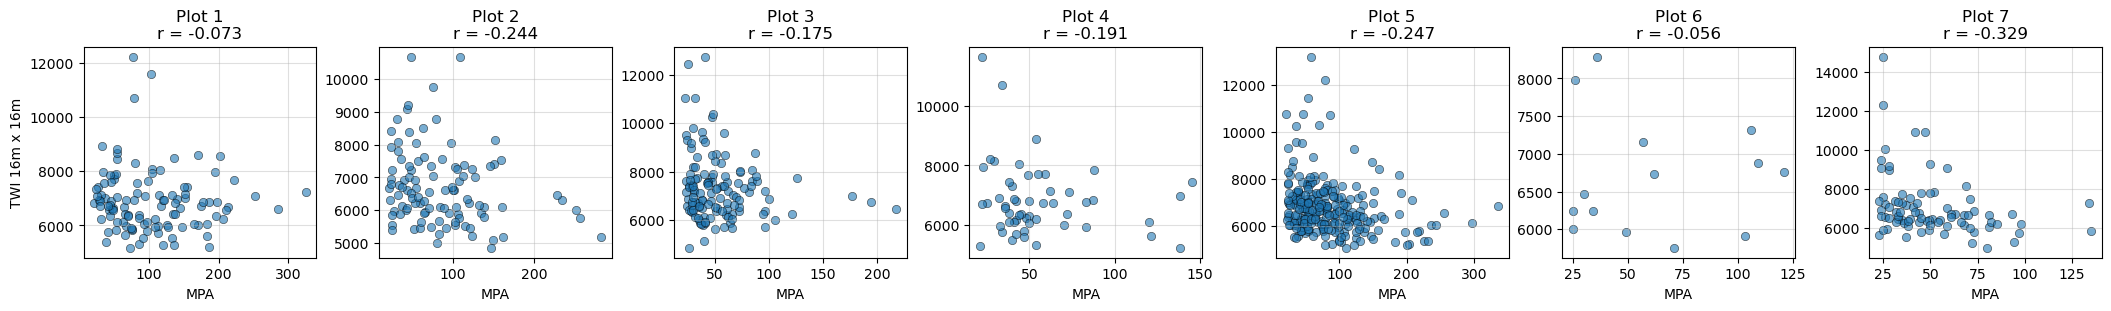

In [13]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 7, figsize=(21, 3), constrained_layout=True)

pearsons = []
for i, ax in enumerate(axes):
    arr = np.asarray(twis[i], dtype=float)
    mpa = np.asarray(mpas[i], dtype=float)

    mask = np.isfinite(arr) & np.isfinite(mpa)
    arr = arr[mask]
    mpa = mpa[mask]

    ax.scatter(mpa, arr, alpha=0.6, edgecolors='k', linewidth=0.5)
    if i == 0:
        ax.set_ylabel("TWI 16m x 16m")
    ax.set_xlabel("MPA")
    ax.grid(True, alpha=0.4)

    if mpa.size >= 2:
        r = float(np.corrcoef(mpa, arr)[0, 1])
    else:
        r = np.nan

    pearsons.append(r)
    ax.set_title(f"Plot {i+1}\nr = {r:.3f}" if np.isfinite(r) else f"Plot {i+1}\nr = NA")

plt.show()